In [297]:
import numpy as np
import matplotlib.pyplot as plt

In [298]:
class Linear():
    def forward(input):
        return input

    def diff(a):
        dhda = a
        return dhda 

class Tanh():
    def forward(input):
        return np.tanh(input)

    def diff(a):
        dhda = 1-np.tanh(a)**2
        return dhda

ActivationHandler = {
    'linear' : Linear,
    'tanh'   : Tanh,
}

def ActivationFunc(activation_func_name):
    return ActivationHandler[activation_func_name]

In [299]:
def Zeros(shape, dtype=None):
    return np.zeros(shape=shape, dtype=dtype)

def RandomNormal(shape):
    return np.random.normal(loc=0, scale=0.05, size=shape)

InitializeHandler = {
    'zeros': Zeros,
    'random_normal': RandomNormal,
}

def Initializer(initializer_name):
    return InitializeHandler[initializer_name]

In [300]:
class mean_squared_error():
    def loss(y_true, y_pred):
        return np.mean(np.square(y_pred - y_true), axis=-1)
    def diff(y_true, y_pred):
        return y_pred-y_true

LossHandler = {
    'mean_squared_error' : mean_squared_error,
}

def LossFunc(loss_func_name):
    return LossHandler[loss_func_name]

In [301]:
class Layers():
    NLayers=1

    def __init__(self, name, units):
        self.name=f"Layer{Layers.NLayers}.{name}"
        self.outdim=units
        self.w = None
        Layers.NLayers+=1

    def build(self, indim):
        self.indim = indim
        self.w = np.c_[
            self.kernel_initializer(shape=(self.outdim,self.indim)),
            self.bias_initializer(shape=(self.outdim,1))
        ]

class Input(Layers):
    def __init__(self, inputdim):
        super().__init__("inputs", inputdim)

class Dense(Layers):
    def __init__(self, units, activation='linear', kernel_initializer='random_normal', bias_initializer='zeros'):
        """
        @param units             : (tuple) dimensionality of the (input space, output space).
        @param activation        : (str) Activation function to use.
        @param kernel_initializer: (str) Initializer for the `kernel` weights matrix.
        @param bias_initializer  : (str) Initializer for the bias vector.
        """        
        super().__init__("dense", units)
        self.kernel_initializer = Initializer(kernel_initializer)
        self.bias_initializer   = Initializer(bias_initializer)
        self.h = ActivationFunc(activation)
        self.z = None
        self.a = None

    def forward(self, input):
        """ @param input: shape=(Din,) """
        z_in = np.append(input,1) # shape=(Din+1,)            
        a = self.w.dot(z_in)      # (Dout,Din+1) @ (Din+1,) = (Dout,)
        z_out = self.h.forward(a) # shape=(Dout,)
        self.z = z_in
        self.a = a
        return z_out

    def backprop(self, dEdz_out):
        """ @param dEdz_out: shape=(Dout,) """
        dEda = self.h.diff(self.a)*dEdz_out # δ, shape=(Dout,)
        dEdz_in = self.w.T.dot(dEda)        # (Din+1,Dout) @ (Dout,) = (Din+1,)
        self.update(dEda)
        return dEdz_in[:-1]                 # shape=(Din,) term of bias is not propagated.

    def update(self, delta, ALPHA=1):
        """ @param delta: shape=(Dout,) """
        dw = np.outer(delta, self.z) # (Dout,) × (Din+1,) = (Dout,Din+1)
        self.w -= ALPHA*dw # update. w → w + ALPHA*dw

In [302]:
class Sequential():
    def __init__(self, layer=None):
        self.layers = []
        self.epochs = 0
        if layer is not None: self.add(layer)
        self.loss = None
        self.config = None

    def add(self, layer):
        """Adds a layer instance."""
        self.layers.append(layer)

    def compile(self, loss, input_shape=None):
        """ Creates the layer weights. """
        self.loss = LossFunc(loss)
        units = [l.outdim for l in self.layers]
        for i,l in enumerate(self.layers):
            if l.name[-6:] == "inputs": continue
            l.build(indim=units[i-1])

    def fit(self, x_train, y_train, epochs=1000):
        goal_epochs = self.epochs+epochs
        digit=len(str(goal_epochs))
        for e in range(epochs):
            for x,y in zip(x_train,y_train):
                out = self.forward(x)
                self.backprop(y, out)
            self.epochs+=1
            y_pred = self.predict(x_train)
            mse = np.mean((y_pred-y_train)**2)
            if self.epochs % 100 == 99: print(f'[{self.epochs+1:{digit}d}/{goal_epochs:{digit}d}] mse={mse:{4}f}')

    def forward(self, input):
        out=input
        for l in self.layers:
            if l.name[-6:] == "inputs": continue
            out=l.forward(out)            
        return out

    def backprop(self, y_true, out):
        dEdz_out = self.loss.diff(y_true, out)
        for l in reversed(self.layers):
            if l.name[-6:] == "inputs": continue
            dEdz_out = l.backprop(dEdz_out)

    def predict(self, x_train):
        if np.ndim(x_train) == 1: 
            return self.forward(x_train)
        else:
            return np.array([self.forward(x) for x in x_train])

In [309]:
model = Sequential(Input(1))
model.add(Dense(10, activation="tanh", kernel_initializer="random_normal", bias_initializer="zeros"))
model.add(Dense(10, activation="tanh", kernel_initializer="random_normal", bias_initializer="zeros"))
model.add(Dense(1, activation="tanh"))

In [310]:
print("Units:   {}".format([l.outdim for l in model.layers]))
print("Layers:  {}".format([l.name for l in model.layers]))
print("Weights: {}".format([l.w for l in model.layers]))
model.compile(loss="mean_squared_error")
print("Weights: {}".format([l.w.shape if l.w is not None else None for l in model.layers]))

Units:   [1, 10, 10, 1]
Layers:  ['Layer5.inputs', 'Layer6.dense', 'Layer7.dense', 'Layer8.dense']
Weights: [None, None, None, None]
Weights: [None, (10, 2), (10, 11), (1, 11)]


In [311]:
N = 1000
func = lambda x:x**2
X = np.linspace(-1, 1, N).reshape(-1,1)
Y = np.vectorize(func)(X)

In [312]:
a = np.array([
 [ 0.04294521,  0.        ],
 [-0.07202989,  0.        ],
 [-0.05457115,  0.        ],
])

b = np.array([
 [-0.02091271,  0.03322586, -0.02828983,  0.        ],
 [ 0.07530736, -0.00955775,  0.09933972,  0.        ],
 [-0.07459121, -0.01057377, -0.01888303,  0.        ],
])

c = np.array([[ 0.03243209, -0.04209234,  0.03517436,  0.        ]])

In [313]:
tmp = [a,b,c]

In [308]:
for layer,w in zip(model.layers[1:],tmp):
    layer.w = w

In [281]:
for layer in model.layers[1:]:
    print(layer.w.shape)

(3, 2)
(3, 4)
(1, 4)


In [282]:
for layer,w in zip(model.layers[1:],tmp):
    print(layer.w)

[[ 0.04294521  0.        ]
 [-0.07202989  0.        ]
 [-0.05457115  0.        ]]
[[-0.02091271  0.03322586 -0.02828983  0.        ]
 [ 0.07530736 -0.00955775  0.09933972  0.        ]
 [-0.07459121 -0.01057377 -0.01888303  0.        ]]
[[ 0.03243209 -0.04209234  0.03517436  0.        ]]


In [314]:
idx = np.arange(len(X))
np.random.shuffle(idx)

In [315]:
X = X[idx,:]
Y = Y[idx,:]

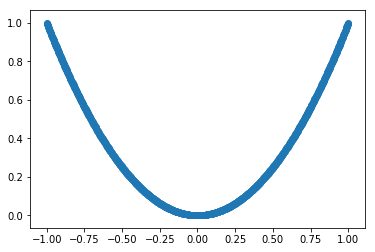

In [316]:
plt.scatter(X,Y)

In [317]:
model.fit(X,Y,epochs=300)

[100/300] mse=0.173272
[200/300] mse=0.173272
[300/300] mse=0.173273


In [318]:
Y_pred = model.predict(X)

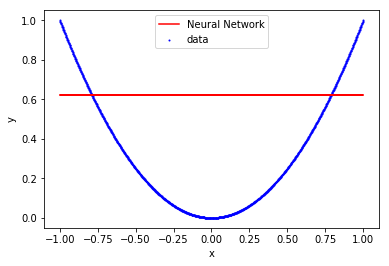

In [319]:
plt.plot(X, Y_pred, label="Neural Network", color="red")
plt.scatter(X, Y, s=1, label="data", color="blue")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [177]:
for l in model.layers[1:]:
    print(l.w)

[[-0.0068016   0.20578694]
 [-0.02798395  0.02394519]
 [-0.05357066  0.27076291]]
[[-0.10808446  0.03842617 -0.12193693 -1.86998864]
 [ 0.08101969  0.02720275  0.1587066   2.1721532 ]
 [-0.14922808 -0.01347841 -0.10957356 -1.95819482]]
[[ 2.68843758 -3.74570328  2.95286747  2.47395041]]


In [90]:
from kerasy.utils import make_batches

In [105]:
num_train_samples = N

In [106]:
batches = make_batches(num_train_samples, 12)
index_array = np.arange(num_train_samples)

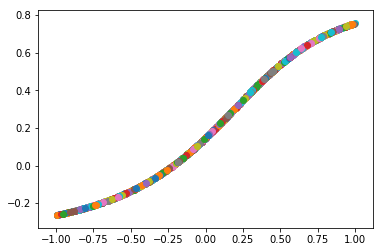

In [114]:
for batch_index, (batch_start, batch_end) in enumerate(batches):
    np.random.shuffle(index_array)
    batch_ids = index_array[batch_start:batch_end]
    for bs, (x_train, y_train) in enumerate(zip(X[batch_ids], Y[batch_ids])):
        plt.scatter(x_train, model.forward(x_train))
plt.show()

In [109]:
for bs, (x_train, y_train) in enumerate(zip(X[batch_ids], Y[batch_ids])):
    print(x_train, y_train)

[-0.91391391] [0.83523864]
[-0.0950951] [0.00904308]
[-0.0970971] [0.00942785]
[-0.1011011] [0.01022143]


In [98]:
index_array

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])